In [1]:
import pandas as pd
import numpy as np
import random

import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM
from linearmodels import PanelOLS

import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.datasets import card

In [2]:
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style("white")

# Do political differences between countries affect their trade flows?
---

## 1. Introduction
- Let's test whether political differences (as measured by Polity scores) affect bilateral tradeflows between countries from 1960-2006.
- Unit of interest is the annual trade relationship between two countries (e.g. NZL-AUS).
- I will first estimate the gravity model of trade and a modified gravity model by including political difference as a explanatory variable.
- I will then look at **three different identification strategies to estimate the effect of political differences on trade flows**:
    - *Fixed Effects*
    - *Arellano-Bond Instrumental Variables*
    - *Anderson-Hsiao Instrumental Variables*
- Physical distance between countries are included controls.

## 2. Summary Statistics
---

In [3]:
# Import data
polity_data = pd.read_csv("../data/trade_polity_full.csv")

# Create a column column of the sum of gdp_o and gdp_d
polity_data['total_gdp'] = polity_data['gdp_o'] + polity_data['gdp_d']

In [4]:
polity_data.columns

Index(['tradelink', 'year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw',
       'pop_o', 'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d',
       'iso2_d', 'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'polity_o', 'polity_d', 'polity_dist',
       'log_gdp_o', 'log_gdp_d', 'log_flow', 'log_distw', 'log_polity_dist',
       'log_col_hist', 'total_gdp'],
      dtype='object')

In [5]:
# Filter tradelinks with highest average trade volume over time

links = polity_data.groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = polity_data[polity_data['tradelink'].isin(links)]

### 2.1 Trade flows between 1990-2006 for top 10 tradelinks with highest trade flows

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Trade Flow (current US$ million)')]

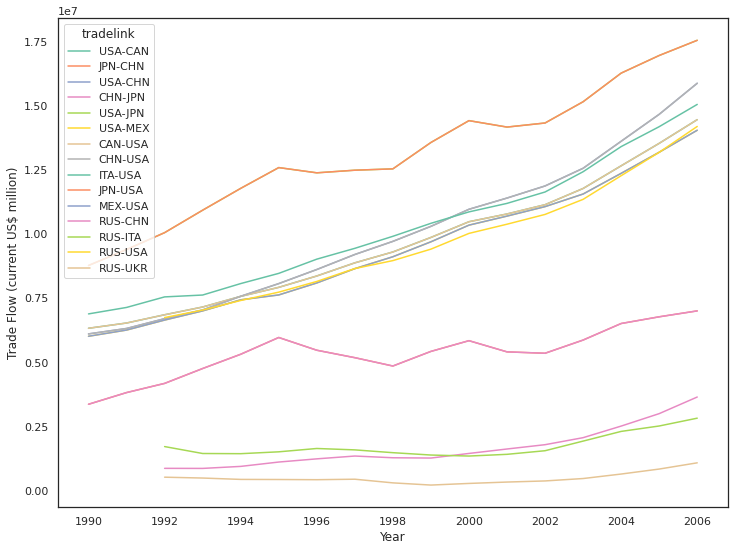

In [6]:
# Tradeflows across top 10 tradelinks with highest average total trade value over time

ax = sns.lineplot(x='year',y='total_gdp', hue='tradelink', data=largest_tradelinks.query('year >= 1990'), palette='Set2')
ax.set(xlabel='Year', ylabel='Trade Flow (current US$ million)')

### 2.2 Jointplot of Polity Distance and Trade Flows (current USD million)

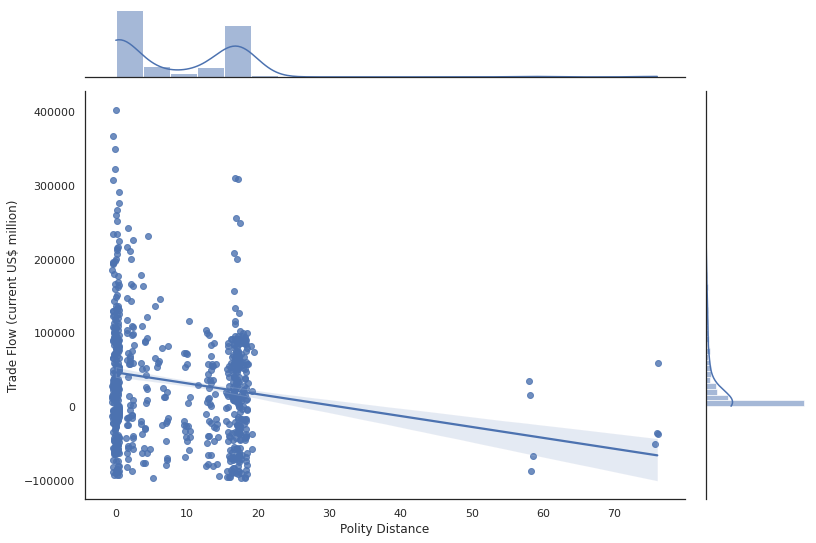

In [7]:
# Joint plot of polity distance and tradeflow

grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', x_jitter=0.5, y_jitter=100000, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Polity Distance', ylabel='Trade Flow (current US$ million)')

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Polity')]

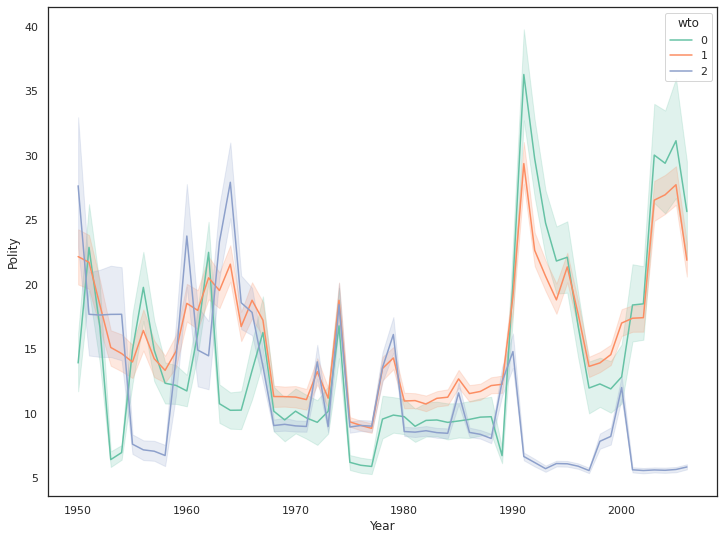

In [8]:
# Change in polity distance over time

polity_data['wto'] = polity_data['gatt_o'] + polity_data['gatt_d']
ax = sns.lineplot(x='year', y='polity_dist', hue='wto', palette='Set2', data=polity_data)
ax.set(xlabel='Year', ylabel='Polity')

In [9]:
polity_data.groupby('year')['wto'].value_counts()

year  wto
1950  1       589
      0       292
      2       223
1951  1       629
      0       296
             ... 
2005  1      1562
      0       193
2006  2      2940
      1      1561
      0       193
Name: wto, Length: 171, dtype: int64

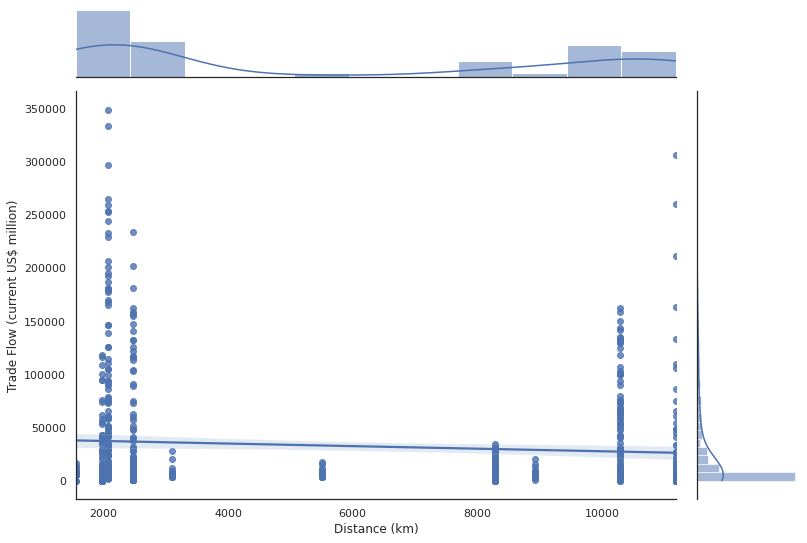

In [10]:
# Relationship between distance and flow

grid = sns.jointplot(x='distw',y='flow', kind='reg',palette='Set2', data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Distance (km)', ylabel='Trade Flow (current US$ million)')

## 3. Results
---

### 3.1.1 Gravity Model

### 3.1.2 Modified Gravity Model

### 3.2 Polity Distance and Tradeflows (Instrumental Variables)

## 4. Comments
---